## Goal:
* Read classified sidewalk data from database
* Clean sidewalks
* Write the result back to the database

## Connect to Database and fetch the data using psycopg2:

In [1]:
import psycopg2

In [2]:
conn = psycopg2.connect(database="****", user="****", password="****", host="****", port="****")
print "Opened database successfully"

Opened database successfully


* Fetch the data:  
each row including a polygon_id (b_id) and geometry (in geoJSON format) of all sidewalks within that polygon

In [3]:
cur = conn.cursor()
cur.execute("SELECT b_id,  st_asgeojson(ST_Collect(sidewalk_geom)) from polygon_sidewalks group by b_id")
rows = cur.fetchall()

* Each row of the fetched data looks like:

In [4]:
for row in rows:
    print row
    break

(1, '{"type":"MultiLineString","coordinates":[[[1255276.99133064,194138.403187305],[1255075.26469998,193527.346994713],[1255066.18433756,193398.133342385]],[[1255076.1321523,193404.484379545],[1255021.58764197,193413.560476884],[1254877.71063314,193461.121733472],[1254858.82976539,193471.062658474],[1254844.39213023,193486.04097496]],[[1255275.28234456,194132.847424135],[1255069.95828015,194291.478668556]],[[1255089.30240156,194300.672219723],[1254838.81701015,193538.456224471],[1254835.50369656,193517.105545387],[1254837.9656339,193499.805383131]]]}')


## Cleaning and Plotting Functions:

In [5]:
# Packages:
import shapely
from shapely.geometry import Point, Polygon, LineString
from copy import deepcopy
import fiona
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()

# Cleaning:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lineAfterList = deepcopy(twoLineList)
    for i in range(len(twoLineList[0])):
        for j in range(len(twoLineList[1])):
            if Point(twoLineList[0][i]).distance(Point(twoLineList[1][j])) < tolClose:
                avgX = (twoLineList[0][i][0] + twoLineList[1][j][0])/float(2)
                avgY = (twoLineList[0][i][1] + twoLineList[1][j][1])/float(2)
                lineAfterList[0][i] = [avgX, avgY]
                lineAfterList[1][j] = [avgX, avgY]
    return lineAfterList

def cleanIfintesectedAlready(twoLineList, tolInt, tolClose):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.length == 0:
        for i in range(len(lines)):
            for j in range(2):
                if Point(lines[i][-j]).distance(intrsct) < tolInt:
                    lines[i][-j] = [intrsct.x, intrsct.y]
        return lines
    else: 
        return connectToAvgIfCloseEnough(lines, tolClose)

def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt,tolClose):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    if intrsct.length == 0:
        numDistanceBelowtolInt = 0
        for line in lines:
            for point in line:
                if Point(point).distance(intrsct) < tolInt:
                    numDistanceBelowtolInt += 1
        if numDistanceBelowtolInt > 1:
            for i in range(len(lines)):
                for j in range(2):
                    if Point(lines[i][-j]).distance(intrsct) < tolInt:
                        lines[i][-j] = [intrsct.x, intrsct.y]
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolInt)
    else:
        return connectToAvgIfCloseEnough(lines, tolInt) #Not by tolClose

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt, tolClose)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt, tolClose)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean
# Plotting:
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

* Clean one group to see if cleaning is working:
* Note: ast.literal_eval changes text to a dictionary

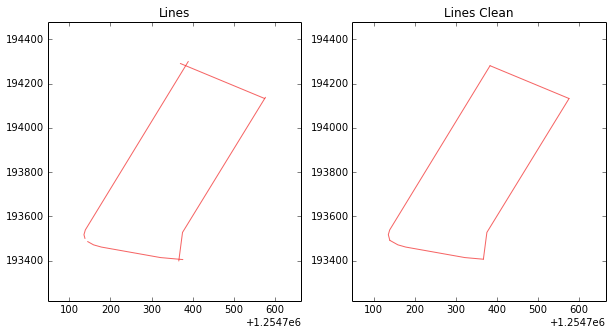

In [6]:
import ast
extL, tolInt, tolClose = 150, 30, 25
cleanSWList = []
for row in rows:
    group = ast.literal_eval(row[1])['coordinates']
    cleanGroup = cleanEachGroup(group, extL, tolInt, tolClose)
    cleanSWList.append((row[0], {'type': 'MultiLineString', 'coordinates': cleanGroup}))
    break
# Plot the results
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in group:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, group, "Lines")
ax = fig.add_subplot(122)
for line in cleanSWList[0][1]['coordinates']:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, group, "Lines Clean")

* Applying the cleaning to **n** polygons which have less than **m** number of sidewalks inside them:

In [9]:
n = 5
m = 7
extL, tolInt, tolClose = 100, 35, 15
SWProcessedList = []
cleanSWList = []
for i in range(n):
    group = ast.literal_eval(rows[i][1])['coordinates']
    if len(group) < m:
        SWProcessedList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': group}))
        cleanGroup = cleanEachGroup(group, extL, tolInt, tolClose)
        cleanSWList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': cleanGroup}))
    else:
        print rows[i][0],i

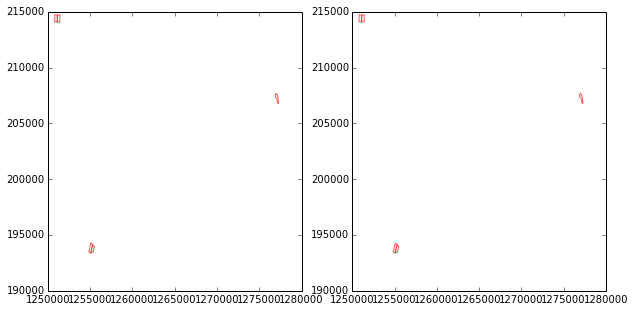

In [10]:
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for row in SWProcessedList:
    for line in row[1]['coordinates']:
        plot_line(ax, line, '#F22222')
# handle_axesLimTitle_for_lineList(ax, firstPol, "Lines")
ax = fig.add_subplot(122)
for element in cleanSWList:
    for line in element[1]['coordinates']:
        plot_line(ax, line, '#F22222')
# handle_axesLimTitle_for_lineList(ax, group, "Lines Clean")

## Create a table called "CleanSW" with two columns:
1. PolygonID: includes Polygon ID
2. SWwithinPolGeom: includes the geometry of all sidewalks within each polygon

In [11]:
conn = psycopg2.connect(database="****", user="****", password="****", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
# Delete the table if already exist
cur.execute('''DROP TABLE IF EXISTS CleanSW''')
# Create table CleanSW
cur.execute('''CREATE TABLE CleanSW (PolygonID INT, SWwithinPolGeom geometry(MULTILINESTRING, 2926));''')
print "Table created"
conn.commit()
conn.close()

Opened database successfully
Table created


## Put clean data into the created table:

In [12]:
conn = psycopg2.connect(database="****", user="****", password="****", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
cur.execute('''TRUNCATE CleanSW''')

for row in cleanSWList:
    cur = conn.cursor()

    cur.execute("INSERT INTO CleanSW (PolygonID, SWwithinPolGeom) \
                VALUES (%s, ST_SetSRID(ST_GeomFromGeoJSON(%s),2926))", (row[0], str(row[1])) );

    conn.commit()
conn.close()
print "Clean Data inserted successfully"

Opened database successfully
Clean Data inserted successfully


## Code:

In [13]:
# Packages:
import ast
import shapely
from shapely.geometry import Point, Polygon, LineString
from copy import deepcopy
import fiona
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()

# Cleaning:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lineAfterList = deepcopy(twoLineList)
    for i in range(len(twoLineList[0])):
        for j in range(len(twoLineList[1])):
            if Point(twoLineList[0][i]).distance(Point(twoLineList[1][j])) < tolClose:
                avgX = (twoLineList[0][i][0] + twoLineList[1][j][0])/float(2)
                avgY = (twoLineList[0][i][1] + twoLineList[1][j][1])/float(2)
                lineAfterList[0][i] = [avgX, avgY]
                lineAfterList[1][j] = [avgX, avgY]
    return lineAfterList

def cleanIfintesectedAlready(twoLineList, tolInt, tolClose):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.length == 0:
        for i in range(len(lines)):
            for j in range(2):
                if Point(lines[i][-j]).distance(intrsct) < tolInt:
                    lines[i][-j] = [intrsct.x, intrsct.y]
        return lines
    else: 
        return connectToAvgIfCloseEnough(lines, tolClose)

def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt,tolClose):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    if intrsct.length == 0:
        numDistanceBelowtolInt = 0
        for line in lines:
            for point in line:
                if Point(point).distance(intrsct) < tolInt:
                    numDistanceBelowtolInt += 1
        if numDistanceBelowtolInt > 1:
            for i in range(len(lines)):
                for j in range(2):
                    if Point(lines[i][-j]).distance(intrsct) < tolInt:
                        lines[i][-j] = [intrsct.x, intrsct.y]
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolInt)
    else:
        return connectToAvgIfCloseEnough(lines, tolInt) #Not by tolClose

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt, tolClose)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt, tolClose)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean
# Plotting:
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

In [14]:
conn = psycopg2.connect(database="****", user="****", password="****", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
cur.execute("SELECT b_id,  st_asgeojson(ST_Collect(sidewalk_geom)) from polygon_sidewalks group by b_id")
rows = cur.fetchall()
print "Data Fetched successfully"

Opened database successfully
Data Fetched successfully


In [15]:
n = 5
m = 7
extL, tolInt, tolClose = 100, 35, 15
SWProcessedList = []
cleanSWList = []
for i in range(n):
    group = ast.literal_eval(rows[i][1])['coordinates']
    if len(group) < m:
        SWProcessedList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': group}))
        cleanGroup = cleanEachGroup(group, extL, tolInt, tolClose)
        cleanSWList.append((rows[i][0], {'type': 'MultiLineString', 'coordinates': cleanGroup}))
    else:
        print rows[i][0],i

In [16]:
conn = psycopg2.connect(database="****", user="****", password="****", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
# Delete the table if already exist
cur.execute('''DROP TABLE IF EXISTS CleanSW''')
# Create table CleanSW
cur.execute('''CREATE TABLE CleanSW (PolygonID INT, SWwithinPolGeom geometry(MULTILINESTRING, 2926));''')
print "Table created"
conn.commit()
conn.close()

Opened database successfully
Table created


In [17]:
conn = psycopg2.connect(database="****", user="****", password="****", host="****", port="****")
print "Opened database successfully"
cur = conn.cursor()
cur.execute('''TRUNCATE CleanSW''')

for row in cleanSWList:
    cur = conn.cursor()

    cur.execute("INSERT INTO CleanSW (PolygonID, SWwithinPolGeom) \
                VALUES (%s, ST_SetSRID(ST_GeomFromGeoJSON(%s),2926))", (row[0], str(row[1])) );

    conn.commit()
conn.close()
print "Clean Data inserted successfully"

Opened database successfully
Clean Data inserted successfully
